In [1]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy
import scipy.ndimage.filters
import numpy.linalg
import illustris_python.groupcat as gc

%matplotlib inline

In [4]:
filename = '/Users/forero/Illustris_data/WEB_CIC_256_DM_TNG300-3.hdf5'
f = h5py.File(filename, 'r')
print(f.keys())
density_smooth = f['density_smooth'][:,:,:]
lambda1 = f['lambda1'][:,:,:]
lambda2 = f['lambda2'][:,:,:]
lambda3 = f['lambda3'][:,:,:]
f.close()

<KeysViewHDF5 ['density_smooth', 'eigenvector1', 'eigenvector2', 'eigenvector3', 'hessian', 'lambda1', 'lambda2', 'lambda3', 'potential']>


In [2]:
basePath = "/Users/forero/Illustris_data/TNG300-1/"

halo_fields = ['GroupFirstSub', 'Group_M_Crit200', 'Group_R_Crit200', 'Group_M_Mean200',
               'GroupNsubs', 'GroupPos', 'GroupVel', 'GroupFirstSub', 'GroupMassType']
halos = gc.loadHalos(basePath,99, fields=halo_fields) # the selection is based on the FOF groups


subhalo_fields = ['SubhaloMass','SubhaloSFRinRad', 'SubhaloPos', 'SubhaloVmax','SubhaloMassType',
                  'SubhaloVel', 'SubhaloParent', 'SubhaloGrNr', 'SubhaloStellarPhotometrics']
subhalos = gc.loadSubhalos(basePath,99, fields=subhalo_fields)
header = gc.loadHeader(basePath,99)
BoxSize = header['BoxSize']
# Photometric bands are: U, B, V, K, g, r, i, z 

In [5]:
hubble = 0.677
r_absolute = subhalos['SubhaloStellarPhotometrics'][:,5]
distance = np.sqrt(subhalos['SubhaloPos'][:,0]**2 + subhalos['SubhaloPos'][:,1]**2 +subhalos['SubhaloPos'][:,2]**2)*(1.0/hubble)*(1.0/1000.0) # queda en Mpc
r_apparent = r_absolute + 5.0*np.log10(distance * 1E6 / 10)
theta = np.rad2deg(np.arccos(subhalos['SubhaloPos'][:,2]*(1.0/hubble)*(1.0/1000)/distance))
print(np.shape(r_absolute))
print(BoxSize)
delta_box = BoxSize*(1/hubble)*(1.0/1000.0)/np.shape(lambda1)[0]
print(delta_box)


(14485709,)
205000.0
1.1828378877400294


309818


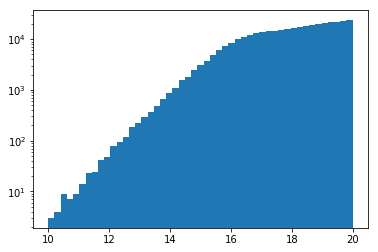

In [6]:
_ = plt.hist(r_apparent, log=True, bins=np.linspace(10,20))
print(np.count_nonzero(r_apparent<19.5))

In [9]:
ii = (distance < 300) & (r_apparent<19.5) & (theta > 45.0)
pos = subhalos['SubhaloPos'][ii] * (1.0/hubble)*(1.0/1000)
vel = subhalos['SubhaloVel'][ii]
vmax = subhalos['SubhaloVmax'][ii]
r_obs = r_apparent[ii]
ii_box = np.int_(pos[:,0]//delta_box)
jj_box = np.int_(pos[:,1]//delta_box)
kk_box = np.int_(pos[:,2]//delta_box)
lambda1_halo = lambda1[ii_box, jj_box, kk_box]
lambda2_halo = lambda2[ii_box, jj_box, kk_box]
lambda3_halo = lambda3[ii_box, jj_box, kk_box]
density_halo = density_smooth[ii_box, jj_box, kk_box]
environment = np.zeros(len(r_obs), dtype=int)

lambda_th = 0.2
ii_void = (lambda1_halo<lambda_th) & (lambda2_halo < lambda_th) & (lambda3_halo < lambda_th)
ii_filament = (lambda1_halo>lambda_th) & (lambda2_halo > lambda_th) & (lambda3_halo < lambda_th)
ii_sheet = (lambda1_halo>lambda_th) & (lambda2_halo < lambda_th) & (lambda3_halo < lambda_th)
ii_peak = (lambda1_halo>lambda_th) & (lambda2_halo > lambda_th) & (lambda3_halo > lambda_th)
environment[ii_void] = 3
environment[ii_filament] = 2
environment[ii_sheet] = 1
environment[ii_peak] = 0

print(ii_box.min(), ii_box.max())
print(jj_box.min(), jj_box.max())
print(kk_box.min(), kk_box.max())

0 253
0 253
0 178


(-14.973906908884715,
 314.78288540289554,
 -14.975097340643485,
 314.7816949711368)

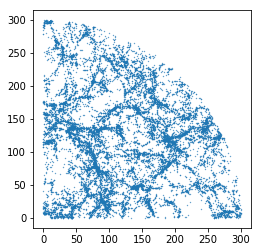

In [8]:
kk = pos[:,2]<20
plt.scatter(pos[kk,0], pos[kk,1], s=0.1)
plt.axis('square')

In [10]:
filename = 'data/mock_TNG300-1.hdf5'
h5f = h5py.File(filename, 'w')
h5f.create_dataset('pos', data=pos)
h5f.create_dataset('vel', data=vel)
h5f.create_dataset('vmax', data=vmax)
h5f.create_dataset('obs_r_mag', data=r_obs)
h5f.create_dataset('lambda1', data=lambda1_halo)
h5f.create_dataset('lambda2', data=lambda2_halo)
h5f.create_dataset('lambda3', data=lambda3_halo)
h5f.create_dataset('density', data=density_halo)
h5f.create_dataset('environment', data=environment)


h5f.close()

In [11]:
filename = 'data/pos_mock_TNG300-1.txt'
np.savetxt(filename, pos)

In [17]:
f = h5py.File('data/mock_TNG300-1.hdf5', 'r')
print(f.keys())
density = f['density'][:]
pos = f['pos'][:,:]
environment = f['environment'][:]
f.close()

<KeysViewHDF5 ['density', 'environment', 'lambda1', 'lambda2', 'lambda3', 'obs_r_mag', 'pos', 'vel', 'vmax']>


Text(0.5,1,'peak')

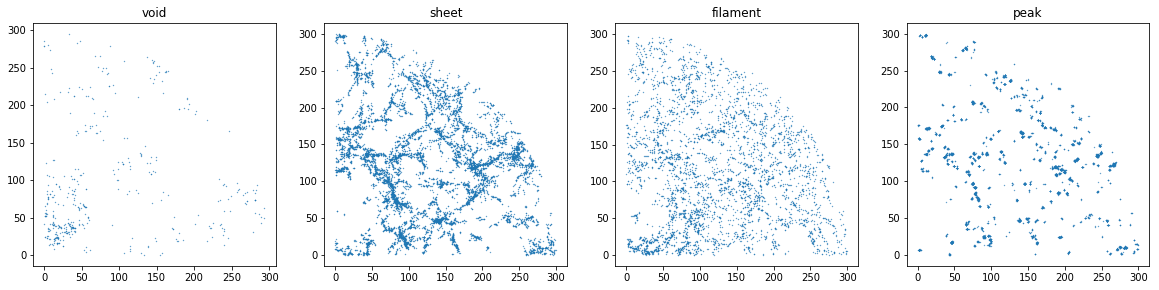

In [20]:
plt.figure(figsize=(20,8))

plt.subplot(1,4,1)
kk = (environment==3) & (pos[:,2]<20)
plt.scatter(pos[kk,0], pos[kk,1], s=0.1)
plt.axis('square')
plt.title('void')

plt.subplot(1,4,2)
kk = (environment==2) & (pos[:,2]<20)
plt.scatter(pos[kk,0], pos[kk,1], s=0.1)
plt.axis('square')
plt.title('sheet')

plt.subplot(1,4,3)
kk = (environment==1) &  (pos[:,2]<20)
plt.scatter(pos[kk,0], pos[kk,1], s=0.1)
plt.axis('square')
plt.title('filament')

plt.subplot(1,4,4)
kk = (environment==0) &  (pos[:,2]<20)
plt.scatter(pos[kk,0], pos[kk,1], s=0.1)
plt.axis('square')
plt.title('peak')